In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Visualizaçao inicial

In [101]:
a = pd.read_csv('reais/4/Iris.csv')
a['Species'] = a['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
a.to_csv('reais/4/Iris.csv', index=False)

In [41]:
df = pd.read_csv(f'/home/bdlemos/Faculdade/Semestre_5/ALG2/reais/1/winequality-white.csv', sep=';')
df = df.rename(columns={'quality': 'label'})
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
label                     int64
dtype: object

# K-Means 2 aproximativo guloso

In [35]:
def greedy_k_means(data, k, type=2):
    def dist(p1, p2):
        """Minkowski distance between two points"""
        p = np.array([p1[0], p1[1]])
        q = np.array([p2[0], p2[1]])
        return np.linalg.norm(p - q, type)
    
    def closest(p, centers,):
        """"Return the index of the closest center to a point"""
        d = [dist(p, c) for c in centers]
        return np.argmin(d), min(d)
    data = data.copy()
    n = data.shape[1] - 1
    centers = []
    centers.append(data.sample().values[0,:-1])
    while len(centers) < k:
        #data['closest_i'] = data.apply(lambda x: closest(x.values[:2], centers), axis=1)
        data['closest'] = data.apply(lambda x: closest(x.values[:n], centers)[1], axis=1)
        pos = data['closest'].argmax()
        centers += [data.iloc[pos].values[:n]]
    else:
        data['closest_i'] = data.apply(lambda x: closest(x.values[:n], centers)[0], axis=1)
        data['closest'] = data.apply(lambda x: dist(x.values[:n], centers[int(x['closest_i'])]), axis=1)

    return centers, data['closest'].max(), data['closest_i']

[array([0.55752212, 0.1369863 ]), array([0.26548673, 1.        ]), array([0.03539823, 0.42465753]), array([0.97345133, 0.3869863 ]), array([0.53097345, 0.61643836]), array([0.18584071, 0.02739726])]


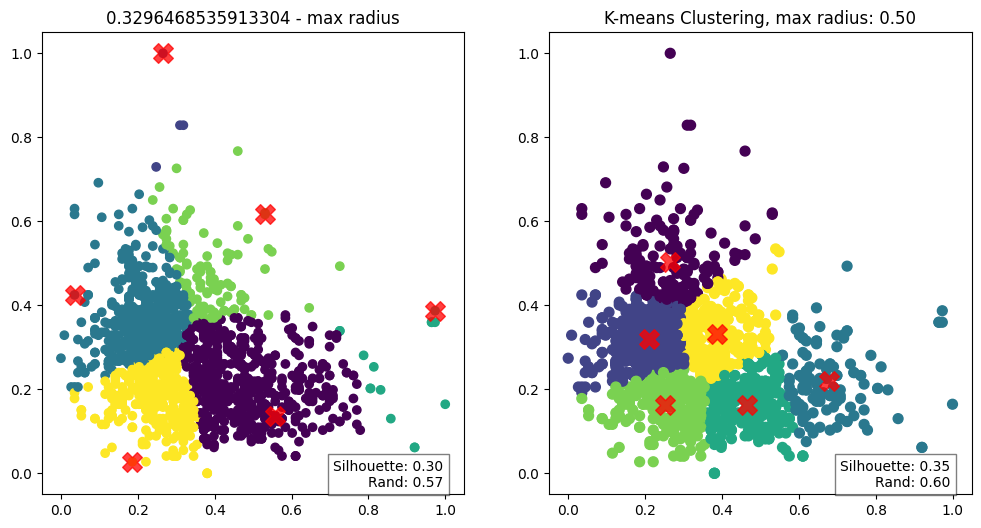

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

# Configurar o tamanho da figura
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
df = pd.read_csv(f'reais/1/winequality-red.csv', sep=';')
df = df.rename(columns={'quality': 'label'})
for column in df.columns:
    if column != 'label':
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
df = df[['fixed acidity', 'volatile acidity', 'label']]
# Parte : Algoritmo greedy_k_means
n = len(df['label'].unique())
centers, max_r, predict = greedy_k_means(df, n, 2)
print(centers)
ss = silhouette_score(df.iloc[:,:-1], predict)
rs = rand_score(df['label'], predict)

# Plotar o resultado do greedy_k_means

# Plotar o resultado do greedy_k_means
ax[0].scatter(df.iloc[:,0], df.iloc[:,1], c=predict)
ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
ax[0].set_title(f'{max_r} - max radius')
ax[0].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[0].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))

# Parte 2: K-means do sklearn
X, y = df.iloc[:, :-1], df['label']
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
labels = kmeans.fit_predict(X)
distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
mar_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X.values)])

# Imprimir métricas
sil_score = silhouette_score(X.values, labels)
rand_score_value = rand_score(y, labels)

# Plotar o resultado do K-means
ax[1].scatter(X.values[:, 0], X.values[:, 1], c=labels, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
           verticalalignment='bottom', horizontalalignment='right',
           transform=ax[1].transAxes, color='black', fontsize=10,
           bbox=dict(facecolor='white', alpha=0.5))
# Configurar título e rótulos
ax[1].set_title(f'K-means Clustering, max radius: {mar_r_sklearn:.2f}')

# Exibir os gráficos
plt.show()



# Gerando metricas

In [112]:
type=1

In [113]:
metrics = []
csv_files = [f'data_{i+1}.csv' for i in range(10)]
csv_files = ['reais/1/winequality-red.csv', 'reais/1/winequality-white.csv', 'reais/2/Dry_Bean_Dataset.csv', 'reais/3/ObesityDataSet_raw_and_data_sinthetic.csv','reais/4/Iris.csv']
for i,csv in enumerate(tqdm(csv_files)):
    if i < 2:
        df = pd.read_csv(f'{csv}', sep=';')
    else:
            df = pd.read_csv(f'{csv}')
    for column in df.columns[:-1]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    columns = df.columns[:5].tolist() + [df.columns[-1]]
    df = df[columns]
    n = len(df['label'].unique())
    df = df
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    for j in range(30):
        start = time.time()
        centers, max_r, predict = greedy_k_means(df, n,type)
        end = time.time()
        radius.append(max_r)
        times.append(end-start)
        sillhouette_s.append(silhouette_score(df.iloc[:,:-1], predict))
        rand_s.append(rand_score(df['label'], predict))
    
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_greedy = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])

100%|██████████| 5/5 [01:29<00:00, 17.83s/it]


In [114]:
df_greedy.to_csv(f'/home/bdlemos/Faculdade/Semestre_5/ALG2/reais/greedy_metrics_{type}.csv', index=False)
df_greedy

,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,0.401396,0.034906,0.258521,0.105621,0.049697,0.535055,0.029792
1,0.383233,0.026468,0.819429,0.187948,0.076294,0.422559,0.049285
2,0.205782,0.018333,0.689037,0.245597,0.096711,0.710095,0.035233
3,0.390405,0.026524,0.410065,0.026159,0.010971,0.638541,0.048050
4,0.626995,0.081592,0.010655,0.364980,0.059064,0.796257,0.041518


In [115]:
metrics = []
csv_files = [f'data_{i+1}.csv' for i in range(10)]
csv_files = ['reais/1/winequality-red.csv', 'reais/1/winequality-white.csv', 'reais/2/Dry_Bean_Dataset.csv', 'reais/3/ObesityDataSet_raw_and_data_sinthetic.csv','reais/4/Iris.csv']
for i,csv in enumerate(tqdm(csv_files)):
    if i < 2:
        df = pd.read_csv(f'{csv}', sep=';')
    else:
            df = pd.read_csv(f'{csv}')
    for column in df.columns[:-1]:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    columns = df.columns[:5].tolist()
    X, y = df[columns], df['label']
    def dist(p1, p2):
        """Minkowski distance between two points"""
        p = np.array([p1[0], p1[1]])
        q = np.array([p2[0], p2[1]])
        return np.linalg.norm(p - q, type)

    n = len(df['label'].unique())
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    for j in range(30):
        start = time.time()
        kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
        labels = kmeans.fit_predict(X)
        #distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
        # distance = lambda x1, x2: np.sum(np.abs(x1 - x2)**type)**(1/type)
        mar_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X.values)])
        end = time.time()
        radius.append(mar_r_sklearn)
        times.append(end-start)
        sillhouette_s.append(silhouette_score(X.values, labels))
        rand_s.append(rand_score(y, labels))
    
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_sklearn = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])
df_sklearn.to_csv(f'/home/bdlemos/Faculdade/Semestre_5/ALG2/reais/sklearn_metrics_{type}.csv', index=False)
df_sklearn

100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_rand_s
0,0.631803,2.220446e-16,0.052878,0.269983,5.551115e-17,0.589248,1.110223e-16
1,0.588071,9.288792e-17,0.124221,0.218755,5.551115e-17,0.616556,1.110223e-16
2,0.393707,1.110223e-16,0.120712,0.425514,5.551115e-17,0.889433,0.000000e+00
3,0.603294,1.110223e-16,0.111290,0.289893,1.110223e-16,0.788475,2.220446e-16
4,0.349705,1.665335e-16,0.003082,0.520362,0.000000e+00,0.973960,2.220446e-16


<Axes: >

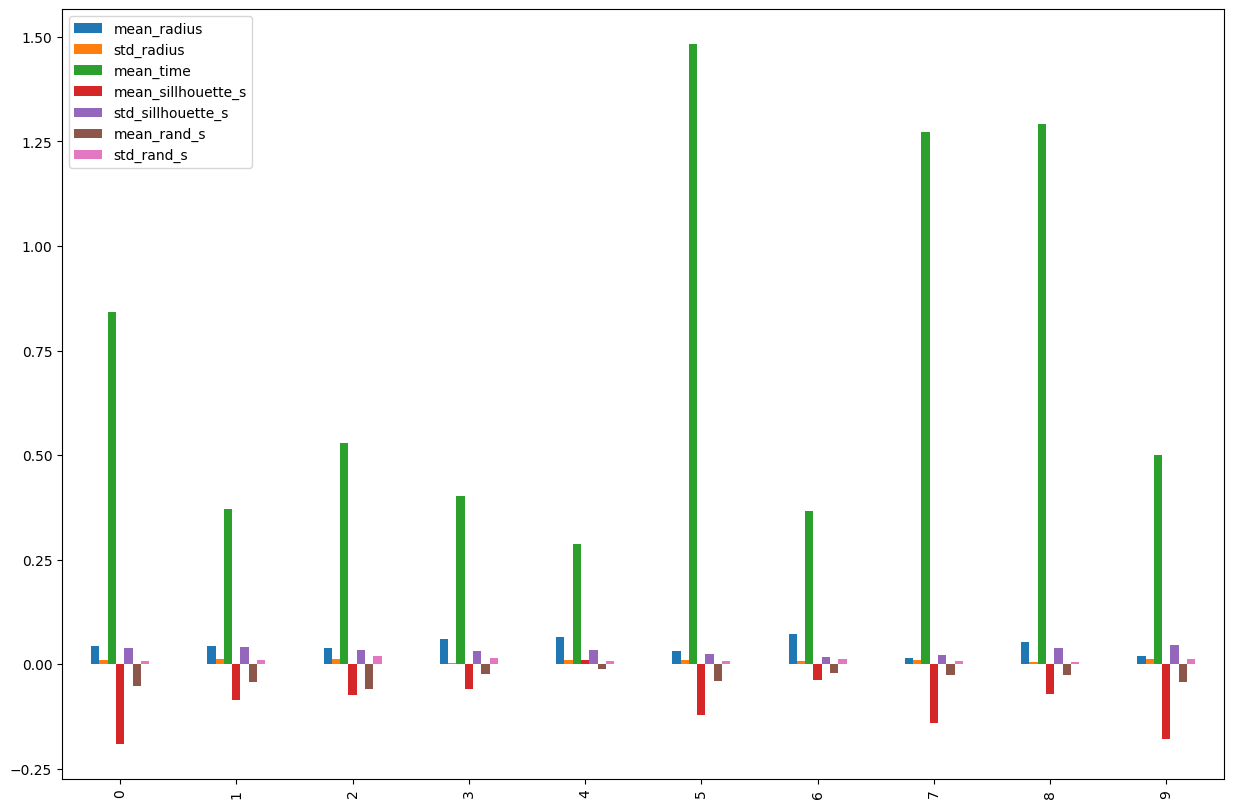

In [48]:
df_media = df_greedy-df_sklearn
df_media.plot(kind = 'bar',figsize=(15,10))

In [57]:
df_media = pd.DataFrame()
df_media['proporcao'] = df_greedy['mean_radius']/df_sklearn['mean_radius'].mean()
df_media['diferenca_sillhouette'] = df_greedy['mean_sillhouette_s'] - df_sklearn['mean_sillhouette_s']
df_media['diferenca_rand'] = df_greedy['mean_rand_s'] - df_sklearn['mean_rand_s']
df_media['diferenca_tempo'] = df_greedy['mean_time'] - df_sklearn['mean_time']
df_media.mean()

proporcao                1.308265
diferenca_sillhouette   -0.094962
diferenca_rand          -0.034023
diferenca_tempo          0.734945
dtype: float64

<Axes: title={'center': 'Densidade da proporção do raio greedy/sklearn'}, ylabel='Density'>

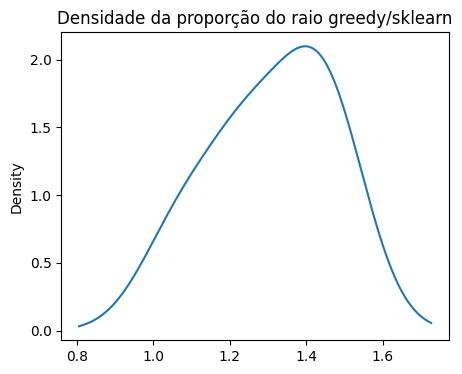

In [74]:
df_media['proporcao'].plot(kind = 'density',figsize=(5,4), title='Densidade da proporção do raio greedy/sklearn')

<Axes: ylabel='Density'>

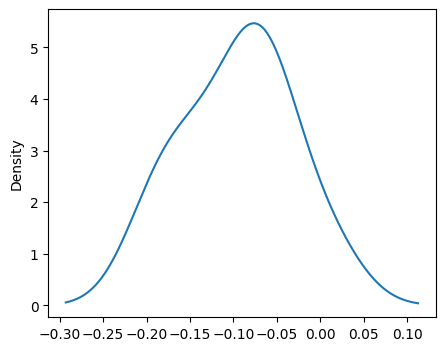

In [69]:
df_media['diferenca_sillhouette'].plot(kind = 'density',figsize=(5,4))